# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

**Predictors**

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,code
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [5]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()
#levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [data.code.nunique(), data.type_house.nunique()]
cat_feat_df['sample'] = [levels_code[:5], levels_type_house]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,code,136,"[nan, W91, Y35, D08, D6W]"
1,type_house,2,"[house, nan, apartment]"


## Split Data

QUITAR LAS VARIABLES AL FINAL DEL NOTEBOOK ANTERIOR

In [6]:
features = [
    'price',
    'floor_area',
#    'views',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = data[features].copy()
data.shape

(7344, 8)

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

We will use the following metrics to evaluate the models:

LaTeX

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

Transformations

https://scikit-learn.org/stable/modules/preprocessing.html

# Models

## Baseline Model

## Multiple Linear Regression

We are going to use the `transformer_estimator` function to encoder categorical variables, transform numerical variables and input the median to numerical variables and fill with `None` categorical ones with missing values.

Then we will use the `scores_statistics` function to plot the metrics after do cross_validation.

In [9]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                          levels_list=[levels_code, levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1, 
                                          num_feat=num_features,
                                          cat_feat=cat_features
                                         )

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.6374349945410162
r2 std: 0.012912199777471572 

MAE mean: -114418.88963605864
MAE std: 3394.13979668874 

MAPE mean: -0.36543579410468696
MAPE std: 0.01058551901766196 

RMSE mean: -182740.4483172581
RMSE std: 12436.193072335369 



------------

------------

### Overfitting Analysis

Now we are plotting the metrics for the train and test sets. We will use the `metrics_regression` function to do that.

In [10]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6551712152369503
MAE: 111219.00114165794
MAPE: 0.3535933873202516
RMSE: 178541.6203793212

Performance on the test set:
 ----------
R²: 0.6085209054967977
MAE: 106647.88418470204
MAPE: 0.35875487330810074
RMSE: 159561.26423196032



Mean absolute error in the train set is only 5,000€ greater than in the test set so we can consider that there is not overfitting.

### Residuals Diagnostic

The `residuals` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

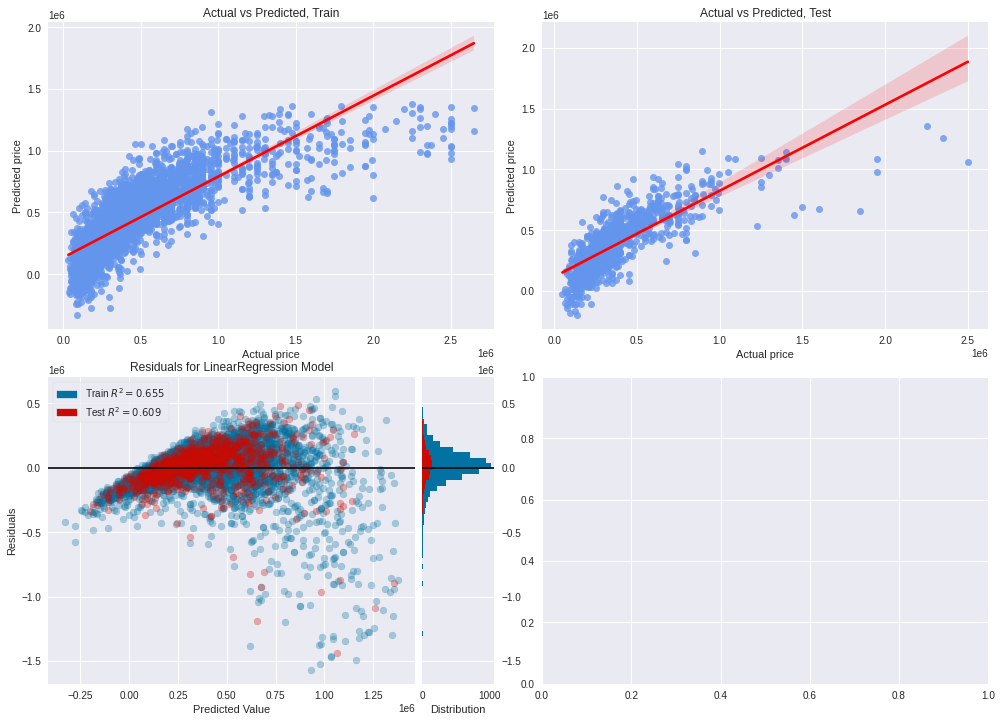

In [11]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

The residuals are calculated extracting `y_train` from `y_pred_train`: y_pred_train - y_train

- The model predices a few negative values, which is not possible in the real world.
- The model doesn't predice well the price of expensive houses. When a house is very expensive the model tends to understimate it.
- We can consider that there is not overfitting.

## Polynomial Regression

First we will instance the GridSearchCV class and fit it to the training set to figure out the best hyperparameters. In this case we will try only different degrees to see what polinomial regression is the best.

In [12]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 4}
0.7638349740456016


In [13]:
# pd.DataFrame(grid_search.cv_results_) # plotearlo

Once we have the best degree we use it to get an estimator and use it as a parameter to the function `scores_statistics`, as we did earlier. 

In [14]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7467290377784661
r2 std: 0.015198326634632667 

MAE mean: -94985.62130842489
MAE std: 2724.448120054538 

MAPE mean: -0.27569541803651565
MAPE std: 0.00847708561170826 

RMSE mean: -152531.75880434347
RMSE std: 8386.588330059374 



### Overfitting Analysis

In [15]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.770997604128686
MAE: 90740.7544458421
MAPE: 0.2623611086739001
RMSE: 145498.236380684

Performance on the test set:
 ----------
R²: 0.7403146388733013
MAE: 84601.18310813041
MAPE: 0.26600073844139427
RMSE: 129956.17351551869



As we can see the polynomial regression with degree three perform better than a multiple linear regression.

### Residuals Diagnostic

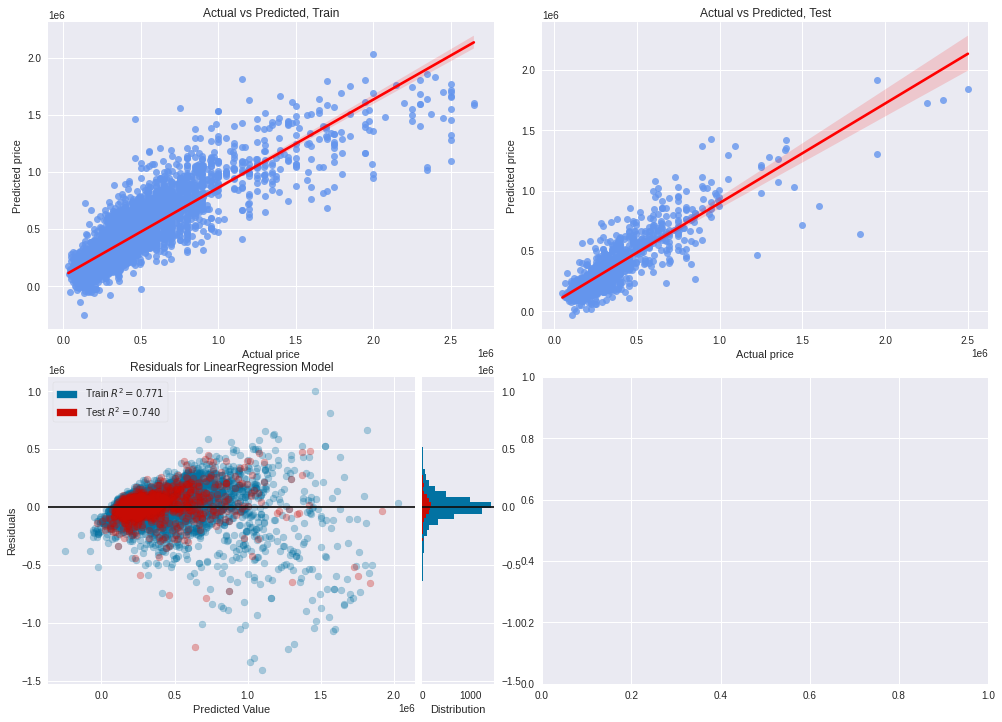

In [16]:
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

- The model still predices a few negative values.
- The model doesn't predice well the price of expensive houses. It also tends to understimate the value of expensive houses but is better than the linear regression.
- We can consider that there is not overfitting.

## K Nearest Neighbors Regressor

In [17]:
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7547665305603588


In [18]:
# We use weights = 'uniform' instead of 'distance' to reduce overfitting
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', # distanc hace que haya mucho overfititng
                                                                          leaf_size= 30), 
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=knnr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False, 
                                          return_est=True
                                         )

r2 mean: 0.7395196974354233
r2 std: 0.016654307798403017 

MAE mean: -90084.9840678037
MAE std: 2690.9787385692184 

MAPE mean: -0.24768038753542349
MAPE std: 0.0077573151026093965 

RMSE mean: -154678.94843571965
RMSE std: 8960.714178182843 



In [19]:
len(scores['estimator'])#[0] == scores['estimator'][2]

5

Surgen tantos estimators como splits de modo que crearemos otro para que los imputers trabajen con todos los valores.

### Overfitting Analysis

In [20]:
knnr = knnr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.813909492892464
MAE: 76046.11665217191
MAPE: 0.2085554753434216
RMSE: 131159.52217378622

Performance on the test set:
 ----------
R²: 0.7354667799127486
MAE: 79403.06637282862
MAPE: 0.22902629397052057
RMSE: 131163.58859948494



The difference between performance in the training set is similar to the test set so it is okay in my opinion.

### Residuals Diagnostic

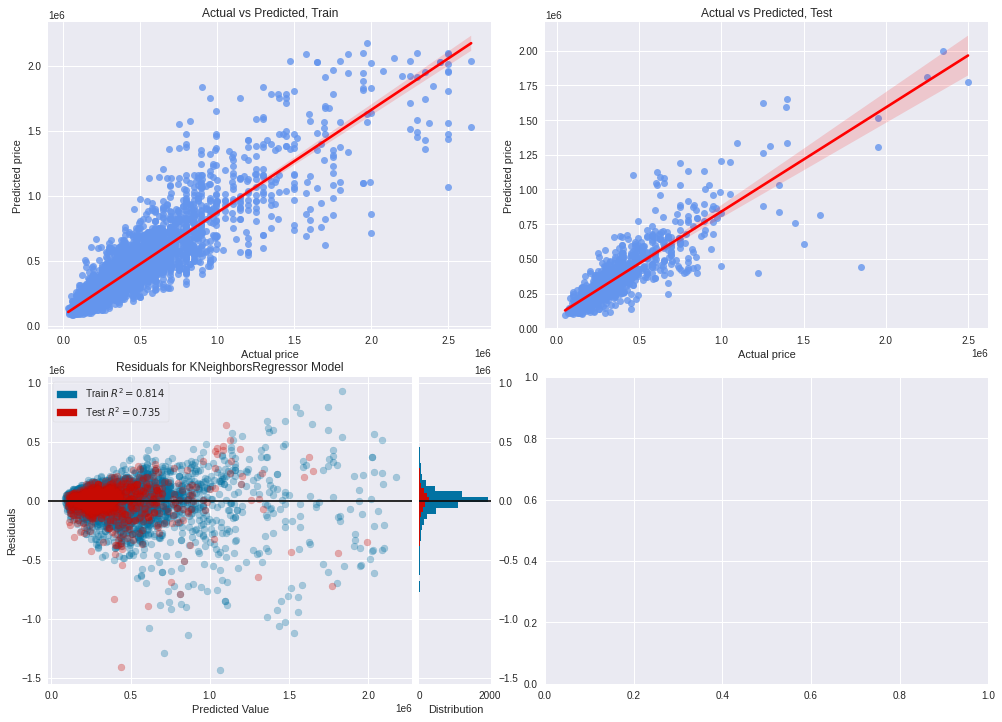

In [21]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

- This time we don't have negative values!
- The model is not very good predicing prices of houses with actual prices above a million, but there is no so clear tendency to understimate them as in the previous models, but there it is.
- There is a litle bit more overfitting than in the previous one but is not too much. It is okay in my opinion.

## Decision Tree Regressor

In [22]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 13, 'regressor__min_samples_leaf': 25}
0.7419495691509257


In [23]:
#pd.DataFrame(grid_search.cv_results_)

In [24]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(max_depth=10,
                                                                           min_samples_leaf=30,  #16
                                                                       #   min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=3,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7238381146567896
r2 std: 0.01548140095500371 

MAE mean: -95809.61232324314
MAE std: 2923.082642942105 

MAPE mean: -0.27137845660769544
MAPE std: 0.008746029843785547 

RMSE mean: -159337.26441609501
RMSE std: 9752.359326981537 



### Overfitting Analysis

In [25]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7796071905921366
MAE: 83858.88782988206
MAPE: 0.23745635880920332
RMSE: 142736.95464148003

Performance on the test set:
 ----------
R²: 0.7151906394069198
MAE: 83672.65032369243
MAPE: 0.24664053884644982
RMSE: 136097.55103025943



In [26]:
dtr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('identity',
                                                                   IdentityTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['floor_area', 'bedroom',
                                                   'bathroom', 'longitude',
                                                   'latitude']),
                                                 ('cat',
     

The different in MAE is insignificant so there is no overfitting. I have changed the parameter values to regularize a little the model as the different in the metrics was bigger earlier. That is why the parameters are different that the GridSearchCV ones.

### Residuals Diagnostic

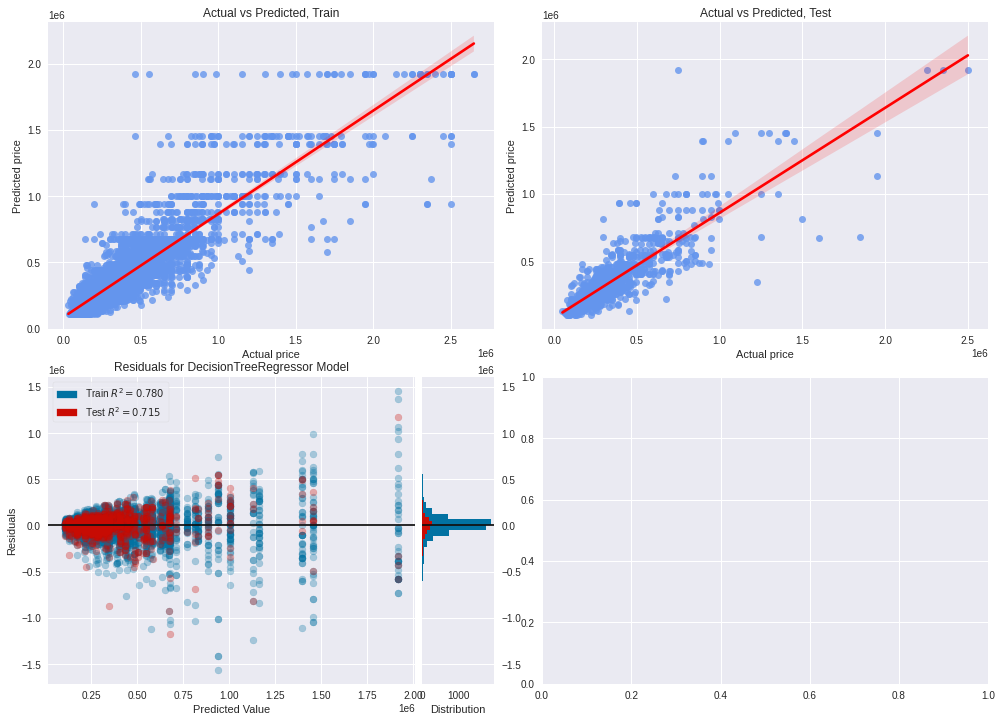

In [27]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

- The model appears to be pretty accurate in values less than 1 million € but the errors increase a lot as the actual price increases as well.
- There is a tendency to understimate values and it is clearer in houses with high values. 
- There is no overfitting.

## Voting Regressor with Basic Algorithms

I think it is interesting to investigate how the basic algorithms we used above can perform together. So let's do a voting regresor with them to figure out that.

In [28]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

Calculate the weights: we will use the performance in the test set to calculate the weights.

In [29]:
models_r2 = {'poly': 74.06, 'knn': 74.57, 'dt': 71.71}

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.3361169102296451,
 'knn': 0.33843151493146956,
 'dt': 0.32545157483888537}

In [30]:
polyr = poly_pipe_estimator
knnr = knnr_pipe_estimator
dtr = dtr_pipe_estimator


voting_regressor_BA = VotingRegressor(
    estimators = [('poly', polyr),
                  ('knn', knnr),
                  ('dt', dtr)], 
    weights = models_weigth_list)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
               'Voting Regressor': voting_regressor_BA}
# Comparing with corss validation
for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7472556995997091
MAE mean: -94617.40072133674
MAPE mean: -0.2745729047492803
RMSE mean: -151978.00196652484
----------
K Nearest Neighbors Regressor
r2 mean: 0.7405510819683749
MAE mean: -89790.28390362638
MAPE mean: -0.24640269754473967
RMSE mean: -153895.63985116727
----------
Decission Tree Regressor
r2 mean: 0.7158522640335984
MAE mean: -95694.09632045394
MAPE mean: -0.2689779848331154
RMSE mean: -160823.66997328144
----------
Voting Regressor
r2 mean: 0.7844165562206153
MAE mean: -82378.37745812135
MAPE mean: -0.23007487700264845
RMSE mean: -140430.78122278795
----------


Cool! We have been able to improve the performance with the voting regressor. Next we will do the overfitting analysisand the residuals diagnostic before start making more complex models. 

### Overfitting Analysis

In [31]:
voting_regressor_BA.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor_BA.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor_BA.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.828208182488559
MAE: 73704.29663110708
MAPE: 0.20648320316975866
RMSE: 126019.84855337627

Performance on the test set:
 ----------
R²: 0.7872573707233286
MAE: 72246.30454242605
MAPE: 0.21746661023966643
RMSE: 117625.21825264425



The different in MAE is less than 2,000€ so we will consider there is no overfitting.

### Residuals Diagnostic

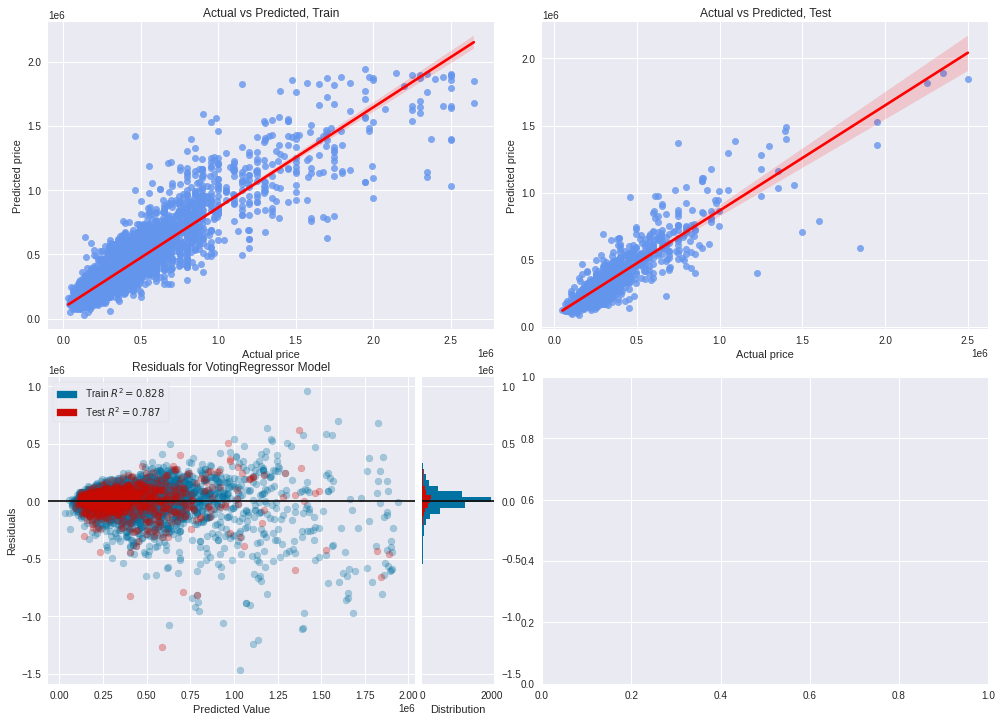

In [32]:
residuals(voting_regressor_BA, X_train, X_test, y_train, y_test)

- The voting regressor is clearly better than the models separately.  
- Once again we can realise that houses which actual price is higher than 1 million € are generally worst predicted than the other ones.
- There is a clear tendency to understimate prices as the actual prices increase. This is normal as the models that make up the voting regressor suffer the same condition.

## Random Forest Regressor

The random forest regressor cells have been runned iteratively several times in order to find the best combination of hyperparameters that maximize the performance while overfitting is under control.

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


Valor óptimo de n_estimators: 41


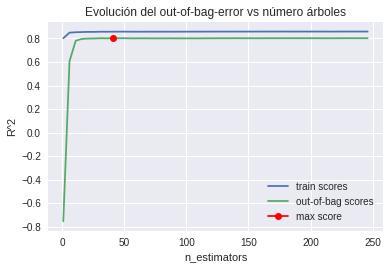

In [33]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 250, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    rfr = transformer_estimator(num_transformation='identity', 
                                regressor=RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=10,
                                    min_samples_leaf=9,  
                                    random_state=7,
                                    bootstrap=True,
                                    n_jobs=-1,
                                    oob_score = True
                                ), 
                                levels_list=[levels_code, levels_type_house],
                                poly_degree=1,
                                num_feat=num_features,
                                cat_feat=cat_features)

    
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    oob_scores.append(rfr.steps[-1][1].oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [34]:
from sklearn.model_selection import RandomizedSearchCV


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [41, 60, 100],
          #       'max_features': range(2, 20, 2), # ['log2', 'sqrt'],
                 'max_depth'   : [None, 3, 10, 20],
           #      'min_samples_split': [2, 5, 8, 15, 20, 43],  # 43
                 'min_samples_leaf': [1, 3, 5, 10, 20, 50],   #16
            #       'max_leaf_nodes': [2, 4, 8, 13, 20, 30, 40, 60, 80],   #68
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = transformer_estimator(num_transformation='identity', 
                                   regressor=RandomForestRegressor(
                              #         n_estimators=n_estimators,
                               #        max_depth=10,
                                #       min_samples_leaf=9,  
                                       random_state=7,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       oob_score = True, 
                                       ** params
                                   ), 
                                   levels_list=[levels_code, levels_type_house],
                                   poly_degree=1,
                                   num_feat=num_features,
                                   cat_feat=cat_features)
    
    

    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.steps[-1][1].oob_score_)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

,oob_r2,max_depth,min_samples_leaf,n_estimators
56,0.818705,20.0,1.0,100.0
5,0.817711,NaN,3.0,100.0
59,0.817398,20.0,3.0,100.0
2,0.817338,NaN,1.0,100.0


Despite the results obtained above if we are so little restrictive with the model and we allow it to have too many degrees of freedom the model will overffit the training data. So I have decided to restrict the model throught some hyperparameters in order to avoid it.

In [35]:
rfr = transformer_estimator(num_transformation='identity', 
                            regressor=RandomForestRegressor(
                                n_estimators=41,    #41
                                max_depth=10,
                                min_samples_leaf=9,  
                                random_state=7,
                                bootstrap=True,
                                n_jobs=-1,
                                oob_score = True 
                            ), 
                            levels_list=[levels_code, levels_type_house],
                            poly_degree=1,
                            num_feat=num_features,
                            cat_feat=cat_features)
    
rfr.fit(X_train, y_train)
print('Train score:', rfr.score(X_train, y_train))
print('Out-of-bag score', rfr.steps[-1][1].oob_score_)

Train score: 0.8575734804083271
Out-of-bag score 0.8023863832100813


### BORRAR?

In [36]:
rfr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               max_depth=10,
                                               min_samples_leaf=9,  
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.794805085411741
r2 std: 0.018036658248585354 

MAE mean: -80471.02557961553
MAE std: 2935.781019924124 

MAPE mean: -0.23063898034981847
MAPE std: 0.007610515994780931 

RMSE mean: -137275.66742463992
RMSE std: 9675.25560325879 



In [37]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8586196034526367
MAE: 67359.8553659591
MAPE: 0.19762119772689613
RMSE: 114322.65816500582

Performance on the test set:
 ----------
R²: 0.7772158761598168
MAE: 71753.75694290017
MAPE: 0.2158624160277241
RMSE: 120369.17957436937



The different between MAE is less than 5,000€ which is okay.

### Residuals Diagnostic

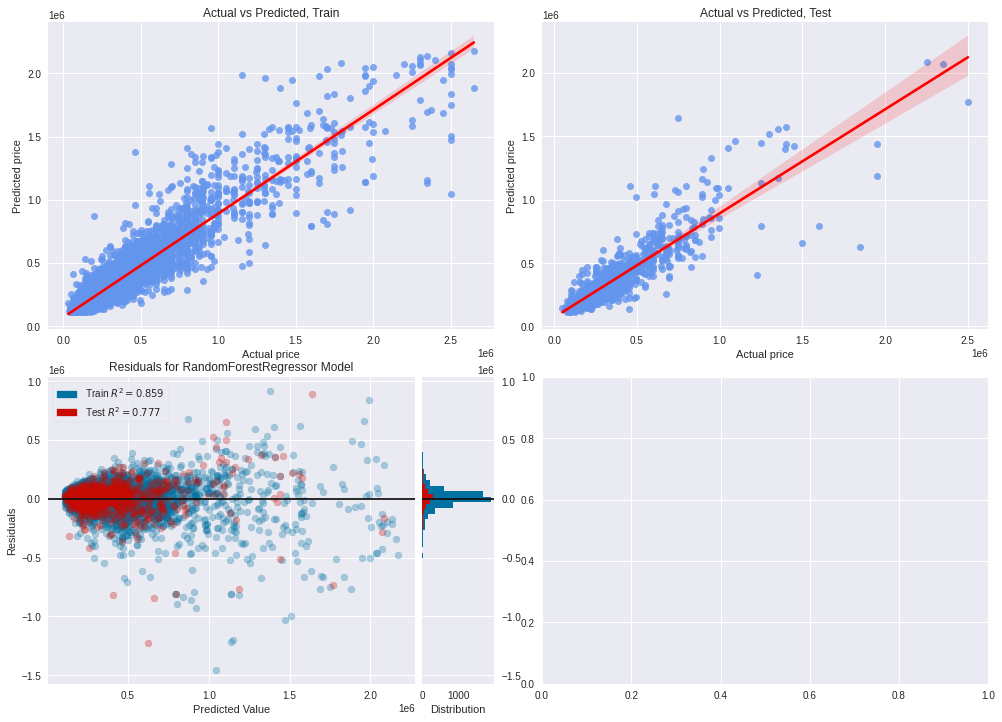

In [38]:
residuals(rfr, X_train, X_test, y_train, y_test)

- The tendency to understimate high values is a little smoother in the random forest.
- The model's performance is better predicting houses prices cheapper than a million euros than highers as well. 
- The voting regressor is still better than the random forest.

## Extreme Gradient Boosting

The next code will give us the RMSE in the traiing set and in the test set 300 times, adding a new estimator every time. This will help us to choose the optimum number of estimators.

In [39]:
# MODIFICAR LA FUNCION PARA HACER ESTO
num_pipe = Pipeline([
            ('identity', PowerTransformer(method='yeo-johnson')),
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('imputer', SimpleImputer(strategy='median')),
            ])
cat_pipe = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories=[levels_code, levels_type_house])), 
        ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
        ])
preprocessor = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features),
        ])
pipe_estimator = Pipeline(steps=[
        ('preprocessor', preprocessor),
    #    ('regressor', regressor),
        ])


df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

X2 = pipe_estimator.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

xgb2 = XGBRegressor(n_estimators= 300, 
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.25)
   
xgb2.fit(X_train2, y_train2,
         eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.46875	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.43750	validation_1-rmse:373322.34375
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355672.06250	validation_1-rmse:313810.00000
[4]	validation_0-rmse:330057.06250	validation_1-rmse:289391.84375
[5]	validation_0-rmse:306698.09375	validation_1-rmse:267665.34375
[6]	validation_0-rmse:286240.09375	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268081.65625	validation_1-rmse:231536.37500
[8]	validation_0-rmse:251999.42188	validation_1-rmse:216863.76562
[9]	validation_0-rmse:238583.01562	validation_1-rmse:205219.40625
[10]	validation_0-rmse:226892.06250	validation_1-rmse:194319.59375
[11]	validation_0-rmse:216022.96875	validation_1-rmse:184938.79688
[12]	validation_0-rmse:207429.68750	validation_1-rmse:177333.15625
[13]	validation_0-rmse:198748.17188	validation_1-rmse:170024.84375
[14]	validation_0-rmse:191730.01562	validation_1-rmse:163887.81250
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

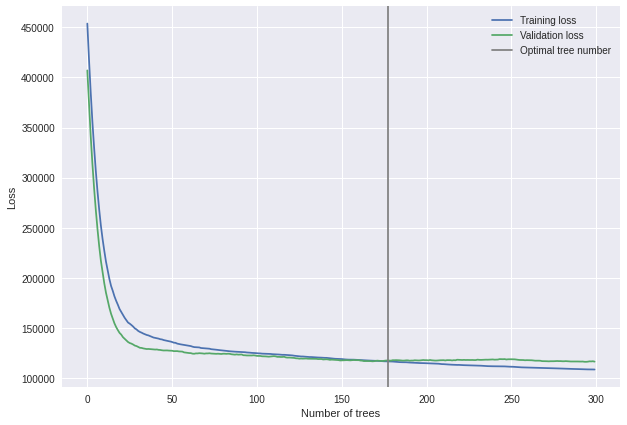

In [40]:
results = xgb2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(177, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

Once we know the optimum number of estimators we can obtain the metrics of our model. After a few iterations I realise that a `max_depth` of 3 helps us reduce overfitting.

In [41]:
xgb_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=XGBRegressor(
                                               n_estimators= 177, #150
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.30),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8010601674838664
r2 std: 0.0342964497397751 

MAE mean: -82504.58731766627
MAE std: 4462.988489004097 

MAPE mean: -0.2382942345142208
MAPE std: 0.010066193385428655 

RMSE mean: -134497.96853927473
RMSE std: 12259.275600604658 



### Overfitting Analysis

In [42]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8576285038595663
MAE: 74929.64309691405
MAPE: 0.2243544160945845
RMSE: 114722.6685761221

Performance on the test set:
 ----------
R²: 0.7890097100558853
MAE: 73284.15001134301
MAPE: 0.22314703160746896
RMSE: 117139.78310464171



### Residuals Diagnostic

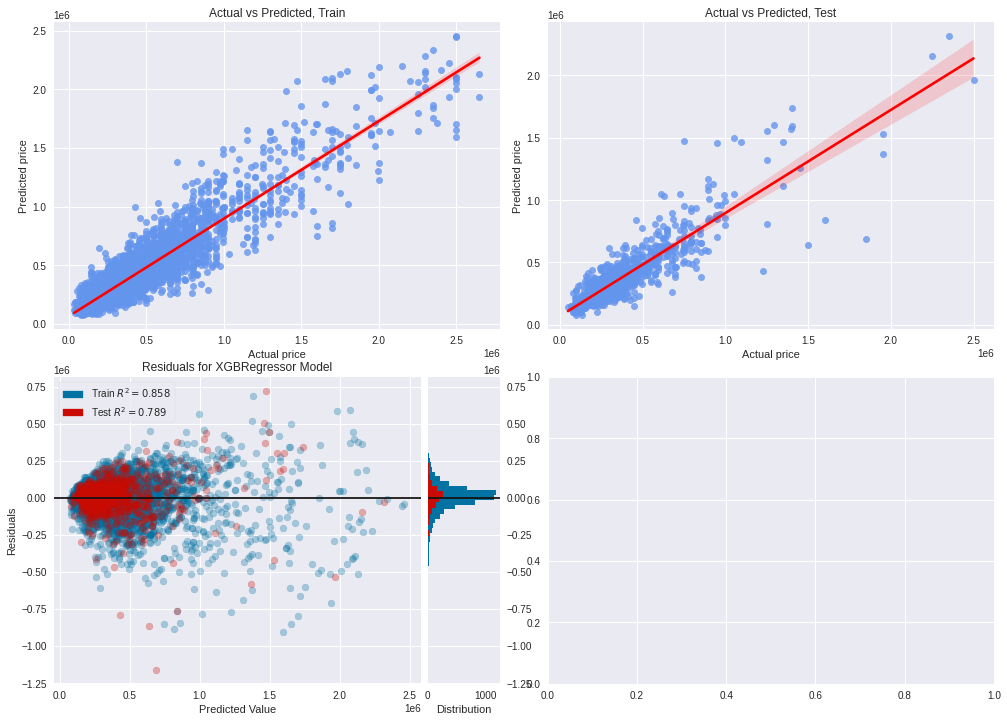

In [43]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

- The XGBRegressor appears to be a little bit better than the Random Forest.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.
- Both XGBRegressor and Voting Regressor with Basic Algorithms.

## Voting Regressor with Ensemble Methods

Now let's see some combinations of voting regressors to see their performance.

The voting regressor that is performing better is the second, made up of:
- Voting Regressor Basic Algorithms
- Random Forest
- Extreme Gradient Boosting

So we will focus on it before try all voting regressors.

### Voting Regressor 1: poly + rfr + xgb

In [44]:
models_r2 = {'poly': 74.06, 'rfr': 80.18, 'xgb': 79.18} 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.3172821523434153,
 'rfr': 0.3435009853482992,
 'xgb': 0.3392168623082855}

In [45]:
polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7472556995997091
MAE mean: -94617.40072133674
----------
Random Forest Regressor
r2 mean: 0.7977509984479338
MAE mean: -79862.50389392684
----------
XGBoost
r2 mean: 0.8010601674838664
MAE mean: -82504.58731766627
----------
Voting Regressor
r2 mean: 0.8073087403724377
MAE mean: -79294.10547721163
----------


In [46]:
voting_regressor1.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor1.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor1.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8525699203890847
MAE: 71855.78139395225
MAPE: 0.208565489374094
RMSE: 116742.97762990459

Performance on the test set:
 ----------
R²: 0.7979383766070101
MAE: 70546.5475938099
MAPE: 0.21584760082280358
RMSE: 114634.43637397459



### Voting Regressor 2: voting_regressor_BA + rfr + xgb 

In [47]:
models_r2 = {'voting_regressor_BA': 79.07, 'rfr': 80.18, 'xgb': 79.18} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_regressor_BA': 0.331627731409638,
 'rfr': 0.336283185840708,
 'xgb': 0.332089082749654}

In [48]:
# voting_regressor_BA = voting_regressor_BA
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7844165562206153
MAE mean: -82378.37745812135
----------
Random Forest Regressor
r2 mean: 0.7977509984479338
MAE mean: -79862.50389392686
----------
XGBoost
r2 mean: 0.8010601674838664
MAE mean: -82504.58731766627
----------
Voting Regressor
r2 mean: 0.8089174332786712
MAE mean: -78195.20091106105
----------


In [49]:
voting_regressor2.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor2.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor2.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8604433964589326
MAE: 69046.22184098607
MAPE: 0.20112076752876337
RMSE: 113582.88924401709

Performance on the test set:
 ----------
R²: 0.7995408074168288
MAE: 69160.1028185822
MAPE: 0.21016708217108201
RMSE: 114178.9827543202



### Voting Regressor 3: rfr + xgb

In [50]:
models_r2 = {'rfr': 80.18, 'xgb': 79.18} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'rfr': 0.5031375502008032, 'xgb': 0.4968624497991968}

In [51]:
#polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.7977509984479338
MAE mean: -79862.50389392686
----------
XGBoost
r2 mean: 0.8010601674838664
MAE mean: -82504.58731766627
----------
Voting Regressor
r2 mean: 0.8090025772269837
MAE mean: -79005.33309997604
----------


In [52]:
voting_regressor3.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor3.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor3.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8664225502135319
MAE: 69346.22749115255
MAPE: 0.20621682621499154
RMSE: 111123.0850677774

Performance on the test set:
 ----------
R²: 0.7923491845131785
MAE: 70489.30770446669
MAPE: 0.21447072487404106
RMSE: 116209.06356968258



### Voting Regressor 4: voting_regressor_BA + rfr

In [53]:
models_r2 = {'voting_regressor_BA': 79.07, 'rfr': 80.18} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_regressor_BA': 0.4965149136577708, 'rfr': 0.5034850863422292}

In [54]:
voting_regressor4 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr)], 
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr,
               'Voting Regressor4': voting_regressor4}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7844165562206153
MAE mean: -82378.37745812135
----------
Random Forest Regressor
r2 mean: 0.7977509984479337
MAE mean: -79862.50389392686
----------
Voting Regressor4
r2 mean: 0.8009621298190283
MAE mean: -78703.09782813066
----------


In [55]:
voting_regressor4.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor4.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor4.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8515286611411378
MAE: 68291.09704717797
MAPE: 0.19548397940865556
RMSE: 117154.51448897773

Performance on the test set:
 ----------
R²: 0.793872329339829
MAE: 69424.34256893331
MAPE: 0.2098172895068063
RMSE: 115782.07508246186



### Residuals Diagnostic Voting Regressor 2: 

Let's get the diagnostic for the second voting regressor.

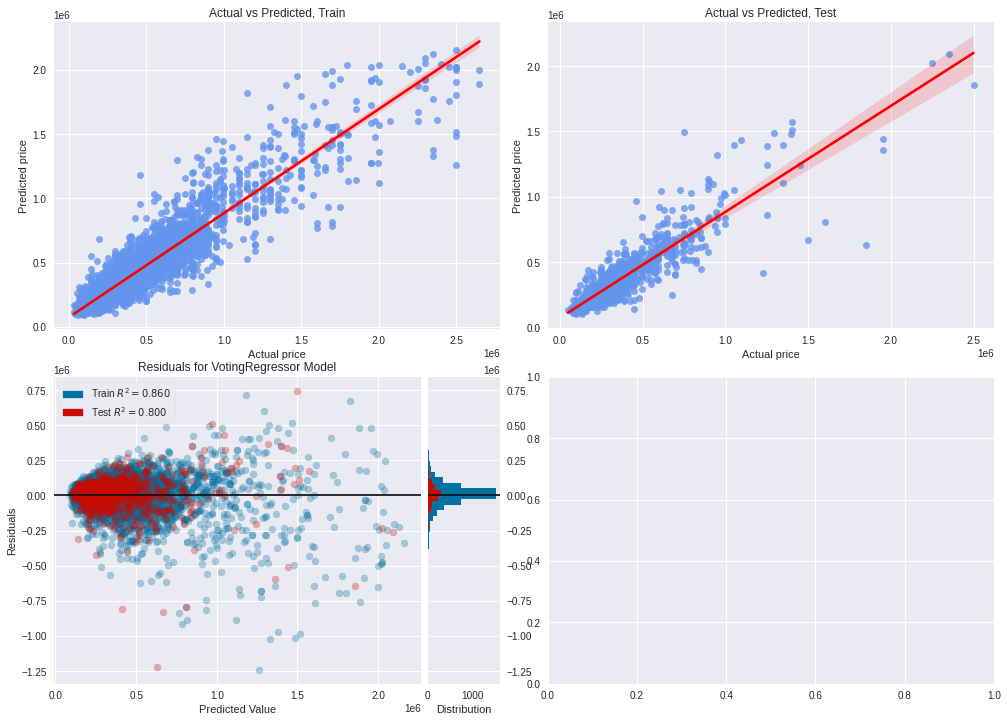

In [56]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

## Stacking

To finish let's train a Stacking model. It will be made up the Voting Regressor with Basic Algorithms and the Extreme Gradient Boosting.

- Regression Meta-Model: Linear Reagression

In [57]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('voting_regressor_BA', voting_regressor_BA))
 #   level0.append(('rfr', rfr))
    level0.append(('xgb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [58]:
models_dict = {'Voting Regressor BA': voting_regressor_BA, 
         #      'Random Forest Regressor': rfr, 
               'XGBoost': xgb_pipe_estimator,
               'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7844165562206153
MAE mean: -82378.37745812135
----------
XGBoost
r2 mean: 0.8010601674838664
MAE mean: -82504.58731766627
----------
Stacking
r2 mean: 0.8072286262951802
MAE mean: -79810.13442194475
----------


### Overfitting Analysis

In [59]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8593688257536576
MAE: 71955.00667104348
MAPE: 0.20748413728489387
RMSE: 114019.33866347623

Performance on the test set:
 ----------
R²: 0.7991331176324803
MAE: 70420.63621564028
MAPE: 0.21023136263318581
RMSE: 114295.03121382577



### Residuals Diagnostic

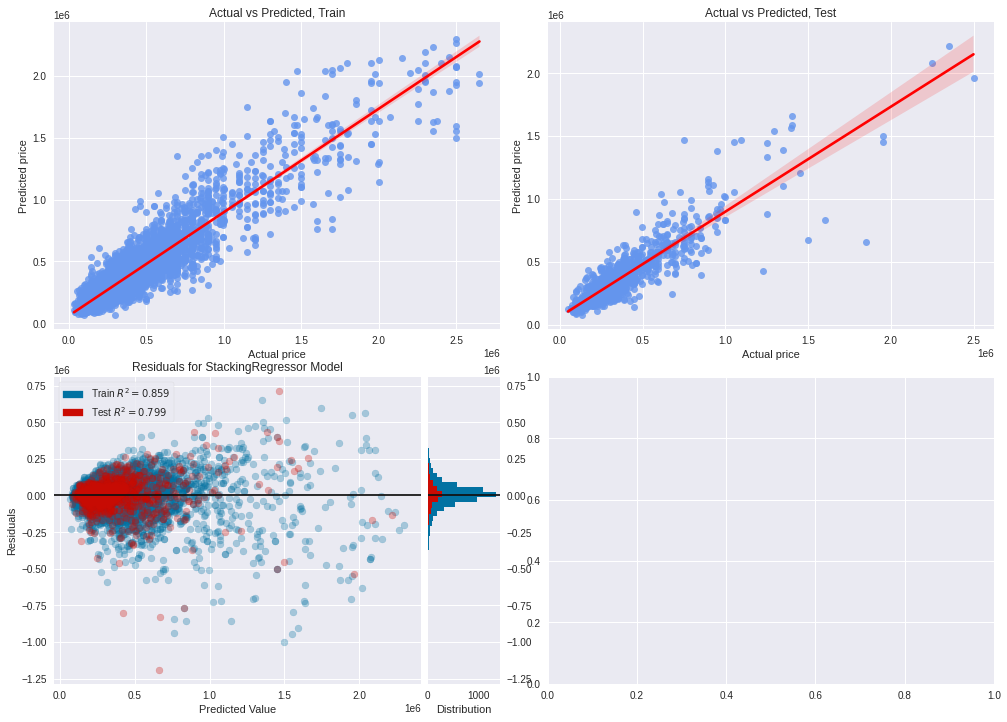

In [60]:
residuals(stacking, X_train, X_test, y_train, y_test)

- We have got some good performance in exchange of supporting more complexity.
- Following the same line as the previous models, the model's performance is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.

# Conclusions and Model Selection

We can deduce some conclusions from the work done in this notebooks.

- The best models obtain an r2 around 0.8 so those models are able to explain an 80% of the variability in prices. In Mean Absolute Error terms this is an error of 69,700€ aproximately when we try its performance in test set. This is not a super good score but it is not very bad as well taking into account the low number of features we are worked with.

- As we were increasing the complexity of the models the performance went up but the improvement wasn't to high so we will need to take a conciencious decision about what model we will use to predict the haouses' prices.

- Most of models tend to understimate houses prices which actual prices are over a million euros. Despite most houses are in the range price under a million this is still worrying. Our models are able to learn the relationship between preditor variables and the response variable better when the actual price of the house is under a million. That could be due to a lack of samples of expensive houses or due to a lack of predictors that can explain better the relationship with the price when it is too much high. Some predictors that perhaps explain that expensive prices could be the house year of construction, the anual income of residents in areas with expensive prices, etc. Also it may be possible that there is no predictors that explain those prices well which would mean that those expensive prices are absolutely disproportionate. 

- Another important aspect is the type of error that is less dangerous. Our model will be used to find potential investment opportunities which means that if the model understimates a house price that house would be less interesting to us as investemnt opportunity, discouraging us to invest money in that operation. That means that we would not win money but we would not loss it either. However, if the model tends to overstimate the price of a house it would be encouraging us to invest in that house so we could buy an asset which value is lower than its price. That means that we could loss money. So we can conclude that a model that tends to understimate asset prices is less dangerous to us that one that tends to overstimate them.

- Some future steps to improve our capability to predict houses prices are the following:
    - Obtain more information from the current variables we have. We could cluster the data or try to combine a few variables to get others with more predicting power.
    - Obtain more information from the current variables we have and other information we don't have as demographic data, income level per capita per area or city, distance from houses to diferent points of interest (schools, museums, universities, public transport, etc), weather data, etc.
    - Also we could try to develop different models for houses with prices under or over a million euros to figure out if it can perform better.
    - Finally we could try deep learning techniques to figure out the performance.
    
   
By the moment we will use the stacking model with a level 0 made up of a voting regressor with basic algorithms and an extreme gradient boosting and a linear regression as meta-model.

# Save Stacking Model

Before saving the winner model we will fit it to all the data instead only the training set. 

In [61]:
# Split data in predictors and target
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


In [62]:
# Get the stacking model we created earlier
houses_prices_stacking_model = get_stacking()
# Fit the model to all the data
houses_prices_stacking_model.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('voting_regressor_BA',
                               VotingRegressor(estimators=[('poly',
                                                            Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              Pipeline(steps=[('power_transformer',
                                                                                                                               PowerTransformer()),
                                                                                                                              ('poly',
                                                                                                                               PolynomialFeatures(degree=3,
                                                         

In [63]:
joblib.dump(houses_prices_stacking_model, 'models/houses_prices_stacking_model.plk')

['models/houses_prices_stacking_model.plk']

In [64]:
model = joblib.load('models/houses_prices_stacking_model.plk')
# model

# Prepare Data for Plotly Dash 

Now we have a trained model that we can use to predict prices. Here we will be using the data the model was trained with as is the data we have, but the model is useful to predict current unseen data from the real market. 

In [65]:
y_pred = model.predict(X)
# We convert y_pred to a list to avoid a problem with nan values
data['predicted_price'] = list(y_pred) 
# The residual is what will tell us whether the asset is a potential opportunity
data['residual'] = data.predicted_price - data.price
data['res_percentage'] = data.residual / data.price

As we are calculating the residuals extracting the  actual price from the predicted one, if the residual is a positive number it means that the predicted price is higher than the actual one so the asset could be an investment opportunity. 

We can see different examples of how the final DataFrame is running the cell below.

In [66]:
data.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,code,predicted_price,residual,res_percentage
5242,319500.0,112,53.297976,-6.490825,3,3,house,D22,362916.62079,43416.62079,0.135889


After running the cell above several times I have realised that I should research more in depth the resulting DataFrame to try to figure out why some houses are better predicted and why others are not.

In [67]:
data.to_csv('data/data_predicted.csv', sep=',', index=False)